In [18]:
import pandas as pd
from aerobot.io import load_training_data, load_validation_data, asset_path
from aerobot.utls import process_data, count_aa_kmers, download_genomes_from_assembly
from aerobot.models import LogisticClassifier
import seaborn as sns

print("Loading data...")
#feature_type = "embedding.genome"
#kmer = 3
#feature_type = f"aa_{kmer}mer"
feature_type = "nt_5mer"
training_data = load_training_data(feature_type=feature_type)
validation_data = load_validation_data(feature_type=feature_type)
cleaned_data = process_data(training_data["features"], training_data["labels"]["physiology"], validation_data["features"], validation_data["labels"]["physiology"])
only_cononical_nts = [x for x in cleaned_data["column_labels"] if len(set(x) - set(["A","C","G","T"])) == 0]
columns_to_keep = [x in only_cononical_nts for x in cleaned_data["column_labels"]]
cleaned_data["X_train"] = cleaned_data["X_train"][:,columns_to_keep]
cleaned_data["X_test"] = cleaned_data["X_test"][:,columns_to_keep]
cleaned_data["column_labels"] = [x for x in cleaned_data["column_labels"] if x in only_cononical_nts]


Loading data...


In [19]:
print("Fitting model...")
model = LogisticClassifier(max_iter=1000000,normalize=True,random_state=None)
model.fit(cleaned_data["X_train"], cleaned_data["y_train"])
accuracy = model.score(cleaned_data["X_train"], cleaned_data["y_train"])
# balanced accuracy
balanced_accuracy = model.balanced_accuracy(cleaned_data["X_train"], cleaned_data["y_train"])
#print accuracy and balanced accuracy
print("Accuracy: " + str(accuracy))
print("Balanced Accuracy: " + str(balanced_accuracy))

# compute accuracy and balanced accuracy on test set
test_accuracy = model.score(cleaned_data["X_test"], cleaned_data["y_test"])
test_balanced_accuracy = model.balanced_accuracy(cleaned_data["X_test"], cleaned_data["y_test"])
print("Test Accuracy: " + str(test_accuracy))
print("Test Balanced Accuracy: " + str(test_balanced_accuracy))


Fitting model...
Accuracy: 0.8597014925373134
Balanced Accuracy: 0.7536191054903468
Test Accuracy: 0.6893939393939394
Test Balanced Accuracy: 0.6618607729718841


In [20]:
C = model.confusion_matrix(cleaned_data["X_train"], cleaned_data["y_train"])
C= pd.DataFrame(C,index=model.classifier.classes_,columns=model.classifier.classes_)
C.apply(lambda x: x/x.sum(),axis=1)

,Aerobe,Anaerobe,Facultative
Aerobe,0.937391,0.034783,0.027826
Anaerobe,0.085691,0.902662,0.011647
Facultative,0.382979,0.196217,0.420804


In [8]:
import os
import pandas as pd
import glob

# Define the root directory
root_dir = '/Users/joshuagoldford/Documents/work/research_projects/metals_metabolism/data/BlackSea_PRJNA649215/mags_black_sea/'

# Get a list of all .faa files under the root directory
file_paths = glob.glob(root_dir + '**/*.faa', recursive=True)

# Extract the genome ids from the file paths
genome_ids = [os.path.basename(os.path.dirname(path)) for path in file_paths]

# Convert the data into a pandas dataframe
mags = pd.DataFrame({
    'Genome_ID': genome_ids,
    'File_Path': file_paths
})

file_mapper = mags.set_index("File_Path")["Genome_ID"].to_dict()



In [62]:
#cleaned_data["column_labels"]

In [74]:
aa_kmer = count_aa_kmers(mags.File_Path.tolist(),kmer)
aa_kmer = aa_kmer.T
aa_kmer.index = [file_mapper[x] for x in aa_kmer.index.tolist()]
aa_kmer = aa_kmer.reindex(columns=cleaned_data["column_labels"], fill_value=0)
labels = model.predict(aa_kmer)


/Users/joshuagoldford/opt/miniconda3/envs/aerobot/lib/python3.8/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [75]:
labels

array(['Aerobe', 'Anaerobe', 'Aerobe', 'Aerobe', 'Aerobe', 'Aerobe',
       'Aerobe', 'Anaerobe', 'Aerobe', 'Anaerobe', 'Aerobe', 'Aerobe',
       'Aerobe', 'Aerobe', 'Anaerobe', 'Anaerobe', 'Aerobe', 'Anaerobe',
       'Aerobe', 'Anaerobe', 'Anaerobe', 'Aerobe', 'Aerobe', 'Anaerobe',
       'Aerobe', 'Aerobe', 'Aerobe', 'Anaerobe', 'Anaerobe', 'Aerobe',
       'Aerobe', 'Aerobe', 'Anaerobe', 'Anaerobe', 'Anaerobe', 'Anaerobe',
       'Aerobe', 'Aerobe', 'Anaerobe', 'Anaerobe', 'Aerobe', 'Anaerobe',
       'Aerobe', 'Aerobe', 'Aerobe', 'Anaerobe', 'Anaerobe', 'Aerobe',
       'Anaerobe', 'Anaerobe', 'Anaerobe', 'Anaerobe', 'Aerobe',
       'Anaerobe', 'Aerobe', 'Anaerobe', 'Aerobe', 'Aerobe', 'Aerobe',
       'Aerobe', 'Anaerobe', 'Aerobe', 'Aerobe', 'Aerobe', 'Anaerobe',
       'Aerobe', 'Anaerobe', 'Anaerobe', 'Aerobe', 'Aerobe', 'Anaerobe',
       'Aerobe', 'Aerobe', 'Anaerobe', 'Aerobe', 'Anaerobe', 'Anaerobe',
       'Aerobe', 'Anaerobe', 'Aerobe', 'Aerobe', 'Aerobe', 'Aerobe',
  

In [67]:
mag_fraction = pd.read_csv("/Users/joshuagoldford/Documents/work/research_projects/metals_metabolism/data/blackSea.MAGfraction.04Feb2023.csv",index_col=0)
metadata = pd.read_csv("/Users/joshuagoldford/Documents/work/research_projects/metals_metabolism/data/blackSea.metadata.csv",index_col=0)


In [76]:
z = pd.DataFrame(labels,index=aa_kmer.index,columns=["oxygen"])
z = z.join(mag_fraction).dropna(axis=0).fillna(0)
z = z.groupby("oxygen").sum().T
df = metadata.join(z)

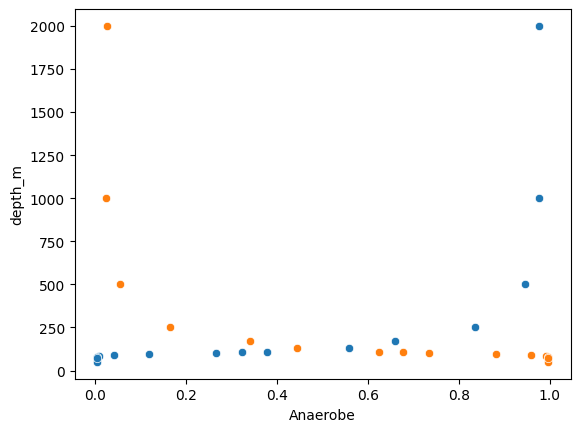

In [77]:
for label in list(set(labels)):
    sns.scatterplot(x=label,y="depth_m",data=df)
    #sns.lineplot(x=label,y="depth_m",data=df)

